In [196]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
import shutil


In [389]:
class data_processor():
    
    def __init__(self):
        self.years     = [2013, 2014, 2015, 2016, 2017, 2018]
        self.suppliers = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
        self.datas     = self.load_data()
        self.month_nums  = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        self.test_data = pd.read_csv('./Submission/test.csv')
        self.model_paths = [ './Models/training_A/Epoch_027_Val_0.055.hdf5', \
                             './Models/training_B/Epoch_023_Val_0.046.hdf5', \
                             './Models/training_C/Epoch_017_Val_0.056.hdf5', \
                             './Models/training_D/Epoch_019_Val_0.047.hdf5', \
                             './Models/training_E/Epoch_017_Val_0.066.hdf5', \
                             './Models/training_G/Epoch_018_Val_0.056.hdf5', \
                             './Models/training_H/Epoch_029_Val_0.014.hdf5']
        
    
    def load_data(self):
        datas = dict()
        for supplier in suppliers:
            datas['data_{}'.format(supplier)] = pd.read_csv('./Data/supplier_{}.csv'.format(supplier)) 
        
        return datas
    
    def get_december_data(self, datas):
        # getting the last day of december (31st) of each year except 2018 for each supplier and return all in a list
        # returns a list of december 31st data for all suppliers
        # each element is december 31st data of each supplier
        training_12_all = []
        for key in datas.keys():
            training_12  = datas[key][ (datas[key]['month'] == 12) & \
                                      (datas[key]['year'].isin([2013, 2014, 2015,2016, 2017])) ].reset_index(drop = True)


            ### for cutting out all december days except the 31st
            training_12 = training_12.sort_values(['year', 'month','day']).reset_index(drop=True)

            #print(training_12['year'].value_counts())
            training_12_cut = []
            for i in range(1,6):
                training_12_cut.append(training_12.iloc[(744*i)-24:744*i])

            training_12_final = pd.concat(training_12_cut, axis = 0).reset_index(drop=True)
            #print(training_12_final['year'].value_counts())
            
            training_12_all.append(training_12_final)
            
        
        return training_12_all
    
    def get_jan_march_data(self, datas):
        # get jan-march for each supplier and return all in a list
        # returns a list of jan-march data for all suppliers 
        # each element is jan-march data of each supplier
        training_1_3_all = []
        
        for key in datas.keys():  
            training_1_3 = datas[key][ (datas[key]['month'].isin([1,2,3])) & \
                             (datas[key]['year'].isin([2014, 2015, 2016, 2017, 2018])) ].reset_index(drop = True)
            
            training_1_3_all.append(training_1_3)
        
        return training_1_3_all
    
    def combine_data(self, training_12_all, training_1_3_all):
        # combine decebmer and jan-march data for each supplier
        # returns a list of december + jan-march data for all suppliers
        # each element is dec + jan-march data for each supplier
        combined_all = []
        
        assert len(training_12_all) == len(training_1_3_all), "december and jan-march data lengths should match"
        
        for i in range(len(training_12_all)):
            training = pd.concat([training_12_all[i], training_1_3_all[i]], axis = 0).reset_index(drop=True)
            training = training.sort_values(['year', 'month']).reset_index(drop=True)
            
            combined_all.append(training)
        
        return combined_all
    
    def separate_data(self, combined_data):
        # separate 12/31 - 3/31 for each pair of year (e.g. 2013-2014, 2014-2015, etc.)
        # so that each pair can be made into lstm input and output 
        # this is important as we don't want dec 31st to be the y-label for march data
        
        indices = []
        for year in self.years[1:]: # march of 2014-2018
            indices.append( combined_data[ (combined_data['year'] == year) & (combined_data['month'] == 3) &\
                           (combined_data['day'] == 31) & (combined_data['시간'] == 24)].index[0] )
        print(indices)
        training_sep = []
        last_idx = 0
        for idx in indices:
            idx = idx + 1 
            #if idx != training_A.shape[0] -1 else idx
            training_sep.append(combined_data[last_idx:idx][['공급량', 'year', 'month', 'day', '시간']])
            last_idx = idx
        
        return training_sep
    
    
    def make_scalers(self, combined_all):
        combined = combined_all[:]
        # change pandas dataframe to numpy ndarray
        for i in range(len(combined_all)): # loop through suppliers 
            supplier = combined[i]['구분'].iloc[0]
            assert supplier == self.suppliers[i], 'suppliers should match'
            combined[i] = combined[i][['공급량', 'year', 'month', 'day', '시간']].values
            #print(combined[i].shape)
            x_scaler = MinMaxScaler()
            y_scaler = MinMaxScaler()
            x_scaler.fit(combined[i])
            y_scaler.fit(combined[i][:, [0]])
            
            path_x = './Scalers/x_scaler_{}.pkl'.format(supplier)
            dump(x_scaler, open(path_x, 'wb'))
            path_y = './Scalers/y_scaler_{}.pkl'.format(supplier)
            dump(y_scaler, open(path_y, 'wb'))
            
        
    
    def create_LSTM_Input(self, data, seq_length, step_size):
        final_data = np.zeros((data.shape[0]-seq_length, int(seq_length/step_size), data.shape[1]))

        length = data.shape[0]

        for i in range(final_data.shape[0]):
            final_data[i] = data[i:i+seq_length:step_size]

        return final_data

    def create_LSTM_Output(self, data, seq_length):
        final_output = []
        length = data.shape[0]

        for i in range(seq_length, length):
            final_output.append(data[i])

        final_output = np.array(final_output)
        #final_output = np.expand_dims(final_output, axis = 1)

        return final_output

    
    def separate_data_to_lstm_input(self, sep_data, x_scaler, y_scaler, seq_length): 
        # need to make each chunck 12-3 into lstm inputs SEPARATELY
        # after separating dec-march pairs, we make them into lstm input and output
        # returns all lstm inputs and outputs concatenated vertically 
        lstm_input_lst = []
        lstm_output_lst = []
        for i in range(len(sep_data)):
            sep_values = sep_data[i].values
            x_norm = x_scaler.transform(sep_values)
            #[:,[0, 4]]
            y_norm = y_scaler.transform(sep_values[:, [0]])
            lstm_input_lst.append(self.create_LSTM_Input(x_norm, seq_length, 1))
            lstm_output_lst.append(self.create_LSTM_Output(y_norm, seq_length))


        lstm_input = np.concatenate(lstm_input_lst, axis = 0)
        lstm_output = np.concatenate(lstm_output_lst, axis = 0)
        
        return lstm_input, lstm_output
    
    def preprocess_submission(self, combined_all):
        self.test_data['구분'] = self.test_data['일자|시간|구분'].str[-1]
        self.test_data['연월일'] = pd.to_datetime(self.test_data['일자|시간|구분'].str[:-5])
        self.test_data['시간'] = self.test_data['일자|시간|구분'].str[-4:-2].astype(np.float32)
        
        self.test_data['year']  = self.test_data['연월일'].dt.year
        self.test_data['month'] = self.test_data['연월일'].dt.month
        self.test_data['day']   = self.test_data['연월일'].dt.day
        
        test_all = []
        
        for i in range(len(self.suppliers)):
            test_sup = self.test_data.iloc[2160*i : 2160*(i+1)].reset_index(drop=True)
            test_sup['공급량'] = -100
            #print(test_sup['구분'].value_counts())
            #print(combined_all[i].iloc[-3:][['year', 'month', 'day', '시간']])
            #print(combined_all[i]['구분'].iloc[-1])
            test_sup = test_sup[['구분', '공급량', 'year', 'month', 'day', '시간']]
            
            supplier = self.suppliers[i]
            #past_data = combined_all[i].iloc[-3:][['구분', '공급량', 'year', 'month', 'day', '시간']].reset_index(drop=True)
            past_data = self.get_past_data_submission(supplier)
            
            test_sup = pd.concat([past_data, test_sup], axis = 0).reset_index(drop=True)
            print(test_sup.iloc[:5])
            test_all.append(test_sup.iloc[:, 1:].values)
        
        return test_all
    
    def get_past_data_submission(self, supplier):
        supplier = 'data_{}'.format(supplier)
        past_data  = self.datas[supplier][ (self.datas[supplier]['month'] == 12) & \
                     (self.datas[supplier]['year'] == 2018) ][['구분', '공급량', 'year', 'month', 'day', '시간']].iloc[-3:]
        return past_data
    
    def make_model(self):
        input_x = Input(shape=(3,5)) #(sequence length, num of features) for LSTM; i.e. 50 minutes (sequence of 50 minutes)

        x = LSTM(20, return_sequences=True)(input_x)
        x = BatchNormalization()(x)
        x = Activation('tanh')(x)

        x = LSTM(10, return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = Activation('tanh')(x)

        x = Flatten()(x)

        x = Dense(32)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        output = Dense(1)(x)


        model = Model(inputs = input_x, outputs = output)
        model.compile(loss="mean_absolute_error", optimizer = Adam(lr=0.001)) 
        
        return model
    
    def get_final_submission(self, test_all):
        
        for i in range(len(test_all)):
            test_data = test_all[i]
            model = self.make_model()
            model.load_weights(self.model_paths[i])
            
            supplier = self.suppliers[i]
            x_scaler_path = './Scalers/x_scaler_{}.pkl'.format(supplier)
            y_scaler_path = './Scalers/y_scaler_{}.pkl'.format(supplier)
            x_scaler = load(open(x_scaler_path, 'rb'))
            y_scaler = load(open(y_scaler_path, 'rb'))
            
            for i in range(3, len(test_data)):
                
                input_x = test_data[i-3:i]
                input_x = x_scaler.transform(input_x)
                input_x = np.expand_dims(input_x, axis =0)

                predicted = model.predict(input_x)
                predicted = y_scaler.inverse_transform(predicted)[0][0]
                
                test_data[i, 0] = predicted
                
        
        final_submission = np.concatenate(test_all, axis = 0)
        
        return final_submission
    
    def save_submission(self, final_submission):
        
        submission_all = []
        for i in range(7):
            submission_all.append( final_submission[i*2163+3 : (i+1)*2163] )


        submission = np.concatenate(submission_all, axis = 0)
        submission_supply = pd.DataFrame(submission[:,0])
        submission_csv = pd.read_csv('./Submission/sample_submission.csv')
        submission_csv.iloc[:,1] = submission_supply
        submission_csv.to_csv('./Submission/submission.csv', index = False)
            
            
            
            

In [390]:
import os
os.getcwd()



'/Users/woojaebyun/Documents/Dacon_Gas_Prediction'

In [391]:
os.listdir('./Models/training_H/')




['Epoch_029_Val_0.014.hdf5', '.DS_Store']

In [392]:
dp = data_processor()

In [393]:
dec_data = dp.get_december_data(dp.datas)
jan_march_data = dp.get_jan_march_data(dp.datas)

combined_all = dp.combine_data(dec_data, jan_march_data)

combined_all[0][['공급량', 'year', 'month', 'day', '시간']].values[:5,]

array([[1.901489e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        1.000000e+00],
       [1.706081e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        2.000000e+00],
       [1.533921e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        3.000000e+00],
       [1.611033e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        4.000000e+00],
       [1.792161e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        5.000000e+00]])

In [394]:
sep_data = dp.separate_data(combined_all[6])
print(combined_all[6].iloc[:5])

x_scaler = load(open('./Scalers/x_scaler_H.pkl', 'rb'))
y_scaler = load(open('./Scalers/y_scaler_H.pkl', 'rb'))
lstm_input, lstm_output = dp.separate_data_to_lstm_input(sep_data, x_scaler, y_scaler, 3)

print(lstm_input[0])
print(lstm_output.shape)


print(combined_all[0].iloc[20:25])

[2183, 4367, 6575, 8759, 10943]
   Unnamed: 0         연월일  시간 구분      공급량  year  month  day
0        8736  2013-12-31   1  H  448.692  2013     12   31
1        8737  2013-12-31   2  H  383.316  2013     12   31
2        8738  2013-12-31   3  H  321.844  2013     12   31
3        8739  2013-12-31   4  H  334.348  2013     12   31
4        8740  2013-12-31   5  H  398.196  2013     12   31
[[0.05532686 0.         1.         1.         0.        ]
 [0.04535946 0.         1.         1.         0.04347826]
 [0.03598728 0.         1.         1.         0.08695652]]
(10929, 1)
    Unnamed: 0         연월일  시간 구분       공급량  year  month  day
20        8756  2013-12-31  21  A  2185.665  2013     12   31
21        8757  2013-12-31  22  A  2097.929  2013     12   31
22        8758  2013-12-31  23  A  1999.705  2013     12   31
23        8759  2013-12-31  24  A  1858.169  2013     12   31
24        8760  2014-01-01   1  A  1677.257  2014      1    1


In [395]:
test_all = dp.preprocess_submission(combined_all)
for test in test_all:
    print(test[:3])
#past_data = dp.get_past_data_submission('A')
#past_data
#dp.datas['data_A'].iloc[-3:]
#for test_sup in test_all:
    #print(test_sup[:5])

  구분       공급량  year  month  day    시간
0  A  2840.272  2018     12   31  22.0
1  A  2692.385  2018     12   31  23.0
2  A  2583.340  2018     12   31  24.0
3  A  -100.000  2019      1    1   1.0
4  A  -100.000  2019      1    1   2.0
  구분       공급량  year  month  day    시간
0  B  2540.169  2018     12   31  22.0
1  B  2407.945  2018     12   31  23.0
2  B  2290.154  2018     12   31  24.0
3  B  -100.000  2019      1    1   1.0
4  B  -100.000  2019      1    1   2.0
  구분      공급량  year  month  day    시간
0  C  256.000  2018     12   31  22.0
1  C  246.020  2018     12   31  23.0
2  C  237.911  2018     12   31  24.0
3  C -100.000  2019      1    1   1.0
4  C -100.000  2019      1    1   2.0
  구분       공급량  year  month  day    시간
0  D  1720.595  2018     12   31  22.0
1  D  1624.138  2018     12   31  23.0
2  D  1422.478  2018     12   31  24.0
3  D  -100.000  2019      1    1   1.0
4  D  -100.000  2019      1    1   2.0
  구분       공급량  year  month  day    시간
0  E  3954.210  2018     12   3

In [396]:
final_submission = dp.get_final_submission(test_all)

/Users/woojaebyun/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-10-23 22:01:12.768925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-23 22:01:12.827769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-23 22:01:12.855073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/woojaebyun/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-10-23 22:01:56.013893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

In [414]:
print(final_submission.shape)

submission_all = []
for i in range(7):
    submission_all.append( final_submission[i*2163+3 : (i+1)*2163] )


submission = np.concatenate(submission_all, axis = 0)
submission_supply = pd.DataFrame(submission[:,0])
submission_csv = pd.read_csv('./Submission/sample_submission.csv')
submission_csv.iloc[:,1] = submission_supply
submission_csv.to_csv('./Submission/submission.csv', index = False)

    
for submission in submission_all:
    print(submission.shape)
    print(submission[:3])

submission_csv.columns

(15141, 5)
(2160, 5)
[[1.84255078e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [2.12688135e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  2.00000000e+00]
 [1.67041846e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  3.00000000e+00]]
(2160, 5)
[[2.02685742e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [1.42830042e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  2.00000000e+00]
 [1.51032361e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  3.00000000e+00]]
(2160, 5)
[[1.90097061e+02 2.01900000e+03 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [1.85554565e+02 2.01900000e+03 1.00000000e+00 1.00000000e+00
  2.00000000e+00]
 [2.28014725e+02 2.01900000e+03 1.00000000e+00 1.00000000e+00
  3.00000000e+00]]
(2160, 5)
[[1.06797571e+03 2.01900000e+03 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [9.58042786e+02 2.01900000e+03 1.00000000e+00 1.00000000e+00
  2.00000000e+00]
 [9.35798157e+02 2.01900000e+03 1.00000000e+00 1.00000000e+00
  3.

Index(['일자|시간|구분', '공급량'], dtype='object')

In [361]:
model.load_weights("./Models/training_A/Epoch_027_Val_0.055.hdf5")
x_scaler = load(open('./Scalers/x_scaler_A.pkl', 'rb'))
y_scaler = load(open('./Scalers/y_scaler_A.pkl', 'rb'))

input_x = test_all[0][:3]
print(input_x)
input_x = x_scaler.transform(input_x)
print(input_x)
input_x = np.expand_dims(input_x, axis =0)
print(input_x)
input_x.shape

predicted = model.predict(input_x)
print(predicted)
predicted = y_scaler.inverse_transform(predicted)[0][0]
predicted

print(y_scaler.inverse_transform([[1]])[0][0])

#test_all[0][:10]

[[2840.272 2018.      12.      31.      22.   ]
 [2692.385 2018.      12.      31.      23.   ]
 [2583.34  2018.      12.      31.      24.   ]]
[[0.65064148 1.         1.         1.         0.91304348]
 [0.61088068 1.         1.         1.         0.95652174]
 [0.58156292 1.         1.         1.         1.        ]]
[[[0.65064148 1.         1.         1.         0.91304348]
  [0.61088068 1.         1.         1.         0.95652174]
  [0.58156292 1.         1.         1.         1.        ]]]
[[0.38239482]]
4139.682


In [227]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(lstm_input, lstm_output, test_size = 0.2, random_state = 1311, shuffle=True)


In [189]:
import tensorflow as tf

from tensorflow.keras.layers import Reshape, Dense, Input, LSTM, Flatten, Concatenate, Bidirectional, BatchNormalization, Dropout, ReLU, Activation, ConvLSTM2D, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [326]:
input_x = Input(shape=(3,5)) #(sequence length, num of features) for LSTM; i.e. 50 minutes (sequence of 50 minutes)

x = LSTM(20, return_sequences=True)(input_x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)

x = LSTM(10, return_sequences=True)(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)

x = Flatten()(x)

x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

output = Dense(1)(x)


model = Model(inputs = input_x, outputs = output)
model.compile(loss="mean_absolute_error", optimizer = Adam(lr=0.001)) 
model.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3, 5)]            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 3, 20)             2080      
_________________________________________________________________
batch_normalization_36 (Batc (None, 3, 20)             80        
_________________________________________________________________
activation_36 (Activation)   (None, 3, 20)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 3, 10)             1240      
_________________________________________________________________
batch_normalization_37 (Batc (None, 3, 10)             40        
_________________________________________________________________
activation_37 (Activation)   (None, 3, 10)             0  

/Users/woojaebyun/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [229]:
es = EarlyStopping(monitor='val_loss', mode = 'min' , patience = 10, verbose = 1)

path = './Models/training_{}'.format('H')
if os.path.isdir(path):
    shutil.rmtree(path)

os.makedirs(path, exist_ok = True)

file_path = path + '/Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min',verbose=1, \
                     save_best_only=True, save_weights_only=True)

hist = model.fit(train_x, train_y, batch_size = 128, epochs =30, validation_data = (valid_x, valid_y), callbacks = [es, mc])

Epoch 1/30


2021-10-21 22:41:28.735639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/69 [..............................] - ETA: 1:33 - loss: 0.3836

2021-10-21 22:41:28.987776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:29.021230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:29.076823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:29.122809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.1626

2021-10-21 22:41:31.168805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:31.233445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:31.255792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 4s 33ms/step - loss: 0.1626 - val_loss: 0.0439

Epoch 00001: val_loss improved from inf to 0.04386, saving model to ./Models/training_H/Epoch_001_Val_0.044.hdf5
Epoch 2/30
69/69 [==============================] - 2s 27ms/step - loss: 0.0794 - val_loss: 0.0921

Epoch 00002: val_loss did not improve from 0.04386
Epoch 3/30
69/69 [==============================] - 2s 27ms/step - loss: 0.0609 - val_loss: 0.1067

Epoch 00003: val_loss did not improve from 0.04386
Epoch 4/30
69/69 [==============================] - 2s 26ms/step - loss: 0.0492 - val_loss: 0.1041

Epoch 00004: val_loss did not improve from 0.04386
Epoch 5/30
69/69 [==============================] - 2s 26ms/step - loss: 0.0434 - val_loss: 0.1097

Epoch 00005: val_loss did not improve from 0.04386
Epoch 6/30
69/69 [==============================] - 2s 26ms/step - loss: 0.0390 - val_loss: 0.1048

Epoch 00006: val_loss did not improve from 0.04386
Epoch 7/30
69/69 [=========================

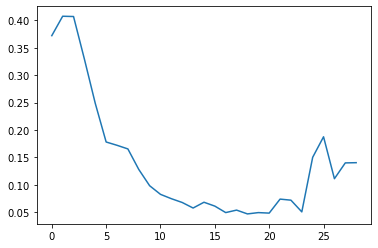

In [217]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_loss'])